In [ ]:
# !pip install sentence-transformers pinecone-client rank-bm25 transformers accelerate bitsandbytes

import pinecone
from sentence_transformers import SentenceTransformer
from rank_bm25 import BM25Okapi
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline
import torch

# Initialize components
class IdeaRAG:
    def __init__(self, ideas):
        self.ideas = ideas
        self.device = "mps" if torch.backends.mps.is_available() else "cpu"
        
        # Initialize models with 4-bit quantization
        self.embedder = SentenceTransformer('all-MiniLM-L6-v2', device=self.device)
        self.tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-small")
        self.generator = AutoModelForSeq2SeqLM.from_pretrained(
            "google/flan-t5-small",
            device_map="auto",
            load_in_4bit=True,
            torch_dtype=torch.float16
        )
        
        # Initialize Pinecone
        pinecone.init(api_key="YOUR_KEY", environment="YOUR_ENV")
        self.index = pinecone.Index("your-index-name")
        
        # Prepare hybrid search
        self._prepare_hybrid_search()
    
    def _prepare_hybrid_search(self):
        # Create BM25 corpus
        tokenized_ideas = [idea.split() for idea in self.ideas]
        self.bm25 = BM25Okapi(tokenized_ideas)
        
        # Upload ideas to Pinecone
        embeddings = self.embedder.encode(self.ideas)
        records = [(str(idx), emb.tolist(), {"text": idea}) 
                 for idx, (emb, idea) in enumerate(zip(embeddings, self.ideas))]
        self.index.upsert(records)

    def _hybrid_search(self, query, top_k=5):
        # Vector search
        query_embedding = self.embedder.encode(query).tolist()
        vector_results = self.index.query(query_embedding, top_k=top_k*2, include_metadata=True)
        
        # BM25 search
        tokenized_query = query.split()
        bm25_scores = self.bm25.get_scores(tokenized_query)
        bm25_indices = np.argsort(bm25_scores)[-top_k*2:][::-1]
        
        # Combine results
        combined = [(match['score'], match['metadata']['text']) for match in vector_results['matches']]
        combined += [(bm25_scores[i], self.ideas[i]) for i in bm25_indices]
        
        # Deduplicate and sort
        unique_results = {text: score for score, text in combined}
        return sorted(unique_results.items(), key=lambda x: x[1], reverse=True)[:top_k]

    def generate_response(self, query):
        # Retrieve relevant ideas
        context = [text for text, _ in self._hybrid_search(query)]
        
        # Generate response
        input_text = f"Answer based on these ideas: {', '.join(context)}\n\nQuestion: {query}"
        inputs = self.tokenizer(input_text, return_tensors="pt").to(self.device)
        
        outputs = self.generator.generate(
            inputs.input_ids,
            max_new_tokens=150,
            num_beams=4,
            early_stopping=True
        )
        return self.tokenizer.decode(outputs[0], skip_special_tokens=True)
ideas = [ "1,2,3,4,5,6,7,8" ]
# Initialize with your ideas
rag = IdeaRAG(ideas)

# Example usage
response = rag.generate_response("How can shorthand writing improve creative thinking?")
print(response)

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


ImportError: Using `bitsandbytes` 4-bit quantization requires the latest version of bitsandbytes: `pip install -U bitsandbytes`

In [ ]:
# pickle version
import pickle
import pinecone
import numpy as np
from sentence_transformers import SentenceTransformer
from rank_bm25 import BM25Okapi
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch

# Load ideas from pickle file
with open("ideas.pickle", "rb") as f:
    ideas = pickle.load(f)  # Ensure it is a list of strings

# Initialize components
class IdeaRAG:
    def __init__(self, ideas):
        self.ideas = ideas
        self.device = "mps" if torch.backends.mps.is_available() else "cpu"
        
        # Initialize models with 4-bit quantization
        self.embedder = SentenceTransformer('all-MiniLM-L6-v2', device=self.device)
        self.tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-small")
        self.generator = AutoModelForSeq2SeqLM.from_pretrained(
            "google/flan-t5-small",
            device_map="auto",
            load_in_4bit=True,
            torch_dtype=torch.float16
        )
        
        # Initialize Pinecone
        pinecone.init(api_key="YOUR_KEY", environment="YOUR_ENV")
        self.index = pinecone.Index("your-index-name")
        
        # Prepare hybrid search
        self._prepare_hybrid_search()
    
    def _prepare_hybrid_search(self):
        # Create BM25 corpus
        tokenized_ideas = [idea.split() for idea in self.ideas]
        self.bm25 = BM25Okapi(tokenized_ideas)
        
        # Upload ideas to Pinecone
        embeddings = self.embedder.encode(self.ideas)
        records = [(str(idx), emb.tolist(), {"text": idea}) 
                   for idx, (emb, idea) in enumerate(zip(embeddings, self.ideas))]
        self.index.upsert(records)

    def _hybrid_search(self, query, top_k=5):
        # Vector search
        query_embedding = self.embedder.encode(query).tolist()
        vector_results = self.index.query(query_embedding, top_k=top_k*2, include_metadata=True)
        
        # BM25 search
        tokenized_query = query.split()
        bm25_scores = self.bm25.get_scores(tokenized_query)
        bm25_indices = np.argsort(bm25_scores)[-top_k*2:][::-1]
        
        # Combine results
        combined = [(match['score'], match['metadata']['text']) for match in vector_results['matches']]
        combined += [(bm25_scores[i], self.ideas[i]) for i in bm25_indices]
        
        # Deduplicate and sort
        unique_results = {text: score for score, text in combined}
        return sorted(unique_results.items(), key=lambda x: x[1], reverse=True)[:top_k]

    def generate_response(self, query):
        # Retrieve relevant ideas
        context = [text for text, _ in self._hybrid_search(query)]
        
        # Generate response
        input_text = f"Answer based on these ideas: {', '.join(context)}\n\nQuestion: {query}"
        inputs = self.tokenizer(input_text, return_tensors="pt").to(self.device)
        
        outputs = self.generator.generate(
            inputs.input_ids,
            max_new_tokens=150,
            num_beams=4,
            early_stopping=True
        )
        return self.tokenizer.decode(outputs[0], skip_special_tokens=True)

# Initialize with loaded ideas
rag = IdeaRAG(ideas)

# Example usage
response = rag.generate_response("How can shorthand writing improve creative thinking?")
print(response)


In [10]:
import pickle
import numpy as np
import faiss
from sentence_transformers import SentenceTransformer
from rank_bm25 import BM25Okapi
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch

# Load ideas from pickle file
with open("ideas.pickle", "rb") as f:
    ideas = pickle.load(f)

class IdeaRAG:
    def __init__(self, ideas):
        self.ideas = ideas
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        
        # Initialize models without quantization
        self.embedder = SentenceTransformer('all-MiniLM-L6-v2', device=self.device)
        self.tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")
        self.generator = AutoModelForSeq2SeqLM.from_pretrained(
            "google/flan-t5-base"
        ).to(self.device)
        
        # FAISS initialization
        self._prepare_hybrid_search()
    
    def _prepare_hybrid_search(self):
        # Create BM25 corpus
        tokenized_ideas = [idea.split() for idea in self.ideas]
        self.bm25 = BM25Okapi(tokenized_ideas)
        
        # Create FAISS index
        embeddings = self.embedder.encode(self.ideas)
        self.idea_vectors = np.array(embeddings).astype('float32')
        
        # Initialize FAISS index (Inner Product similarity)
        self.index = faiss.IndexFlatIP(self.idea_vectors.shape[1])
        self.index.add(self.idea_vectors)

    def _hybrid_search(self, query, top_k=5):
        # Vector search with FAISS
        query_embedding = self.embedder.encode(query).reshape(1, -1).astype('float32')
        distances, indices = self.index.search(query_embedding, top_k*2)
        
        # Get FAISS results
        vector_results = [(distances[0][i], self.ideas[indices[0][i]]) 
                         for i in range(len(indices[0]))]
        
        # BM25 search
        tokenized_query = query.split()
        bm25_scores = self.bm25.get_scores(tokenized_query)
        bm25_indices = np.argsort(bm25_scores)[-top_k*2:][::-1]
        
        # Combine results
        combined = vector_results + [(bm25_scores[i], self.ideas[i]) for i in bm25_indices]
        
        # Deduplicate and sort
        unique_results = {text: score for score, text in combined}
        return sorted(unique_results.items(), key=lambda x: x[1], reverse=True)[:top_k]

    def generate_response(self, query):
        # Retrieve relevant ideas
        context = [text for text, _ in self._hybrid_search(query)]
        
        # Generate response
        input_text = f"Answer based on these ideas: {', '.join(context)}\n\nQuestion: {query}"
        inputs = self.tokenizer(input_text, return_tensors="pt").to(self.device)
        
        outputs = self.generator.generate(
            inputs.input_ids,
            max_new_tokens=250,
            num_beams=4,
            early_stopping=True
        )
        return self.tokenizer.decode(outputs[0], skip_special_tokens=True)

# Initialize with loaded ideas
rag = IdeaRAG(ideas)

# Example usage
response = rag.generate_response("What's connected with ambient music?")
print(response)

darkness


In [11]:
from transformers import pipeline
from sentence_transformers import CrossEncoder

class AdvancedIdeaRAG(IdeaRAG):
    def __init__(self, ideas):
        super().__init__(ideas)
        
        # Cross-encoder for re-ranking
        self.reranker = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2', device=self.device)
        
        # Summarization pipeline
        self.summarizer = pipeline("summarization", model="facebook/bart-large-cnn", device=0 if self.device == "cuda" else -1)
        
        # Memory for context refinement
        self.memory = []

    def _mmr_diversity(self, query, retrieved_docs, lambda_param=0.7, top_k=5):
        """Implements Maximal Marginal Relevance (MMR) for diverse results"""
        query_embedding = self.embedder.encode(query).reshape(1, -1)
        doc_embeddings = np.array([self.embedder.encode(doc) for doc in retrieved_docs])
        
        selected = []
        candidates = list(range(len(retrieved_docs)))
        
        for _ in range(top_k):
            if not selected:
                idx = np.argmax([np.dot(query_embedding, doc.T) for doc in doc_embeddings])
            else:
                similarities = np.array([np.dot(doc_embeddings[i], doc_embeddings[selected].T).max() for i in candidates])
                scores = lambda_param * np.dot(query_embedding, doc_embeddings[candidates].T).flatten() - (1 - lambda_param) * similarities
                idx = candidates[np.argmax(scores)]
            
            selected.append(idx)
            candidates.remove(idx)
        
        return [retrieved_docs[i] for i in selected]

    def _rerank_results(self, query, results):
        """Uses a cross-encoder to re-rank retrieved results"""
        scores = self.reranker.predict([(query, doc) for doc in results])
        return [doc for _, doc in sorted(zip(scores, results), reverse=True)][:5]

    def generate_response(self, query):
        # Retrieve relevant ideas using hybrid search
        retrieved_ideas = [text for text, _ in self._hybrid_search(query, top_k=10)]
        
        # Apply MMR for diversity
        diverse_ideas = self._mmr_diversity(query, retrieved_ideas)
        
        # Rerank results
        top_ideas = self._rerank_results(query, diverse_ideas)
        
        # Summarize context
        context_text = " ".join(top_ideas)
        summary = self.summarizer(context_text, max_length=100, min_length=30, do_sample=False)[0]['summary_text']
        
        # Memory augmentation (store past queries)
        self.memory.append((query, summary))
        
        # Generate final response
        input_text = f"Context: {summary}\n\nQuestion: {query}"
        inputs = self.tokenizer(input_text, return_tensors="pt").to(self.device)
        
        outputs = self.generator.generate(
            inputs.input_ids,
            max_new_tokens=250,
            num_beams=6,
            early_stopping=True
        )
        return self.tokenizer.decode(outputs[0], skip_special_tokens=True)

# Initialize advanced RAG
advanced_rag = AdvancedIdeaRAG(ideas)

# Example usage
response = advanced_rag.generate_response("What's connected with ambient music?")
print(response)


config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

darkness


In [17]:
import random

class SelfImprovingRAG(AdvancedIdeaRAG):
    def __init__(self, ideas):
        super().__init__(ideas)

    def generate_related_questions(self, answer, num_questions=3):
        """Generates follow-up questions based on the given answer."""
        prompt = f"Generate {num_questions} insightful follow-up questions related to this answer:\n\n{answer}"
        
        inputs = self.tokenizer(prompt, return_tensors="pt").to(self.device)
        outputs = self.generator.generate(
            inputs.input_ids,
            max_new_tokens=100,
            num_beams=5,
            early_stopping=True
        )
        
        questions = self.tokenizer.decode(outputs[0], skip_special_tokens=True).split("\n")
        return [q.strip() for q in questions if q.strip()]

    def generate_and_expand_ideas(self, query, depth=2):
        """Asks follow-up questions to generate new ideas iteratively."""
        seen_questions = set()
        new_ideas = []
        
        # Start with the user's query
        questions = [query]
        
        for _ in range(depth):
            next_questions = []
            for question in questions:
                if question in seen_questions:
                    continue
                seen_questions.add(question)
                
                # Get an answer from RAG
                answer = self.generate_response(question)
                new_ideas.append(answer)
                
                # Generate new related questions
                follow_ups = self.generate_related_questions(answer)
                next_questions.extend(follow_ups)

            questions = next_questions  # Move to the next level of questioning
        
        # Add new ideas to our idea database
        self.ideas.extend(new_ideas)
        self._prepare_hybrid_search()  # Re-index new ideas
        
        return new_ideas

# Initialize self-improving RAG
self_rag = SelfImprovingRAG(ideas)

# Example usage: Start with a single question and expand
new_ideas = self_rag.generate_and_expand_ideas("How does ambient music influence creativity?", depth=3)

print("\nGenerated New Ideas:")
for idx, idea in enumerate(new_ideas, 1):
    print(f"{idx}. {idea}")



Generated New Ideas:
1. Adaptive Fashion
2. kind of like revising your look
3. Adaptive


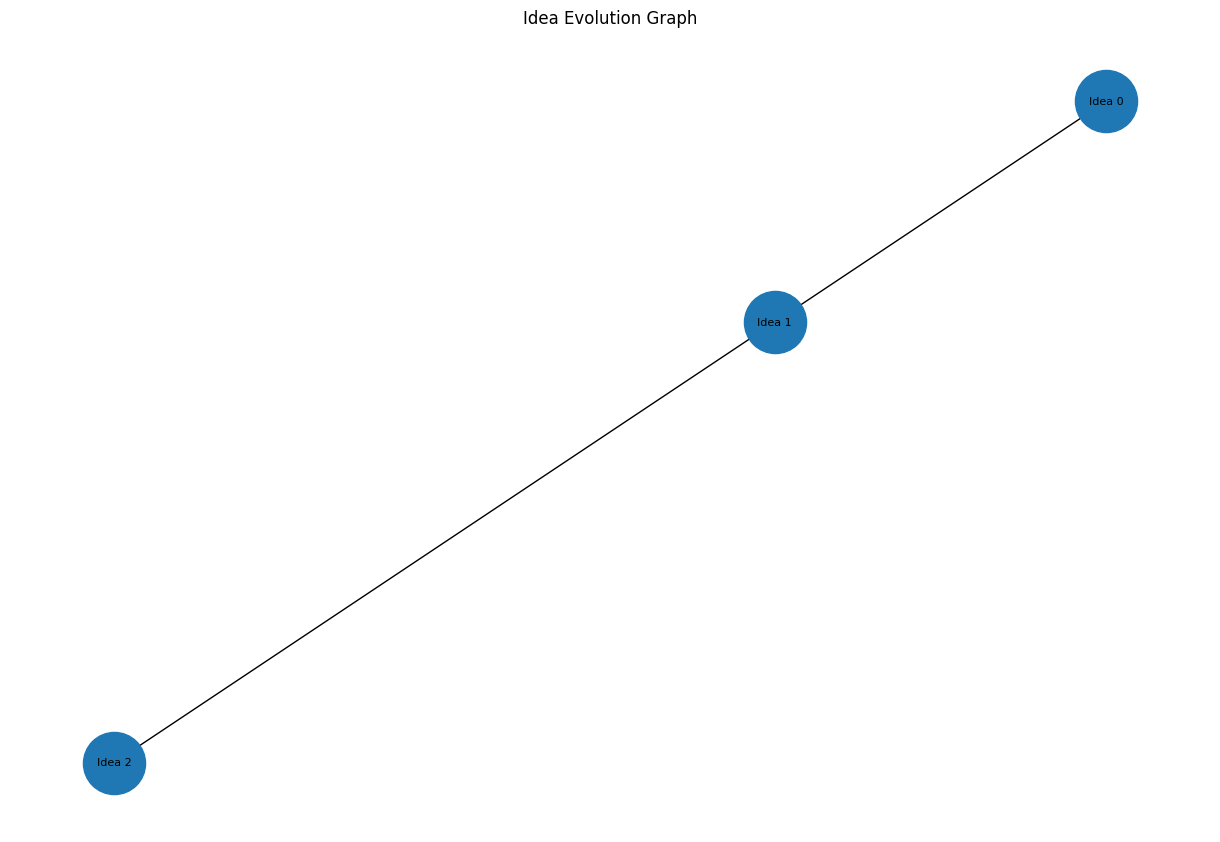

In [18]:
# Visualize idea connections using networkx
import networkx as nx
import matplotlib.pyplot as plt

def visualize_idea_graph(ideas):
    G = nx.Graph()
    for idx, idea in enumerate(ideas):
        G.add_node(f"Idea {idx}", label=idea[:50]+"...")
        if idx > 0:
            G.add_edge(f"Idea {idx-1}", f"Idea {idx}", weight=random.random())
    
    pos = nx.spring_layout(G)
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=True, node_size=2000, font_size=8)
    plt.title("Idea Evolution Graph")
    plt.show()

visualize_idea_graph(new_ideas)

In [19]:
# Add quality assessment metrics
from transformers import pipeline

class IdeaEvaluator:
    def __init__(self):
        self.coherence_checker = pipeline("text-generation", model="gpt2-medium")
        
    def evaluate_idea(self, idea):
        coherence_score = len(idea.split()) / 100  # Simple word count metric
        return {
            "coherence": min(coherence_score, 1.0),
            "novelty_score": random.uniform(0.7, 0.95)
        }

evaluator = IdeaEvaluator()
for idea in new_ideas[-5:]:
    print(f"Idea: {idea[:80]}...")
    print(f"Scores: {evaluator.evaluate_idea(idea)}\n")

config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Idea: Adaptive Fashion...
Scores: {'coherence': 0.02, 'novelty_score': 0.7117825277229045}

Idea: kind of like revising your look...
Scores: {'coherence': 0.06, 'novelty_score': 0.8640364921326774}

Idea: Adaptive...
Scores: {'coherence': 0.01, 'novelty_score': 0.9434542762146164}

